Машинное обучение (семинары в записи)

Урок 3. Классификация на практике

Ссылка на набор данных.

Один из способов повысить эффективность взаимодействия банка с клиентами — отправлять предложение о новой услуге не всем клиентам, а только некоторым, которые выбираются по принципу наибольшей склонности к отклику на это предложение.

Задача заключается в том, чтобы предложить алгоритм, который будет выдавать склонность клиента к положительному или отрицательному отклику на предложение банка. Предполагается, что, получив такие оценки для некоторого множества клиентов, банк обратится с предложением только к тем, от кого ожидается положительный отклик.

Создайте модель линейной регрессии, которая бы оценивала лояльность пользователей к отклику.

Пояснения к признакам набора данных:

• AGREEMENT_RK — уникальный идентификатор объекта в выборке;

• TARGET — целевая переменная: отклик на маркетинговую кампанию (1 — отклик был зарегистрирован, 0 — отклика не было);

• AGE — возраст клиента;

• SOCSTATUS_WORK_FL — социальный статус клиента относительно работы (1 — работает, 0 — не работает);

• SOCSTATUS_PENS_FL — социальный статус клиента относительно пенсии (1 — пенсионер, 0 — не пенсионер);

• GENDER — пол клиента (1 — мужчина, 0 — женщина);

• CHILD_TOTAL — количество детей клиента;

• DEPENDANTS — количество иждивенцев клиента;

• PERSONAL_INCOME — личный доход клиента (в рублях);

• LOAN_NUM_TOTAL — количество ссуд клиента;

• LOAN_NUM_CLOSED — количество погашенных ссуд клиента.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#  Загрузка данных
data = pd.read_csv('ClientsData.csv')

In [3]:
# Просмотр первых строк
print(data.head())

   AGE  SOCSTATUS_WORK_FL  SOCSTATUS_PENS_FL  GENDER  CHILD_TOTAL  DEPENDANTS  \
0   49                  1                  0       1            2           1   
1   32                  1                  0       1            3           3   
2   52                  1                  0       1            4           0   
3   39                  1                  0       1            1           1   
4   30                  1                  0       0            0           0   

   PERSONAL_INCOME  LOAN_NUM_TOTAL  LOAN_NUM_CLOSED  LOAN_DLQ_NUM  TARGET  
0           5000.0               1                1             2       0  
1          12000.0               1                1             1       0  
2           9000.0               2                1             0       0  
3          25000.0               1                1             3       0  
4          12000.0               2                1             2       0  


In [ ]:
# Проверка информации о наборе данных
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AGE                15223 non-null  int64  
 1   SOCSTATUS_WORK_FL  15223 non-null  int64  
 2   SOCSTATUS_PENS_FL  15223 non-null  int64  
 3   GENDER             15223 non-null  int64  
 4   CHILD_TOTAL        15223 non-null  int64  
 5   DEPENDANTS         15223 non-null  int64  
 6   PERSONAL_INCOME    15223 non-null  float64
 7   LOAN_NUM_TOTAL     15223 non-null  int64  
 8   LOAN_NUM_CLOSED    15223 non-null  int64  
 9   LOAN_DLQ_NUM       15223 non-null  int64  
 10  TARGET             15223 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 1.3 MB
None


Из общей информации следует:

Всего 11 колонок, DataFrame содержит 15223 записи, от 0 до 15222

Нулевые значения отсуствуют

Пропущеные значения отсуствуют

Колонка: PERSONAL_INCOME является объектом float64 остальные int64

In [4]:
# Проверка на дубликаты
duplicates = data.duplicated().sum()
print(f"Количество дубликатов: {duplicates}")
if duplicates > 0:
    data = data.drop_duplicates()

Количество дубликатов: 2819


In [5]:
# Проверка на пропущенные значения
print("Пропущенные значения:")
print(data.isnull().sum())

Пропущенные значения:
AGE                  0
SOCSTATUS_WORK_FL    0
SOCSTATUS_PENS_FL    0
GENDER               0
CHILD_TOTAL          0
DEPENDANTS           0
PERSONAL_INCOME      0
LOAN_NUM_TOTAL       0
LOAN_NUM_CLOSED      0
LOAN_DLQ_NUM         0
TARGET               0
dtype: int64


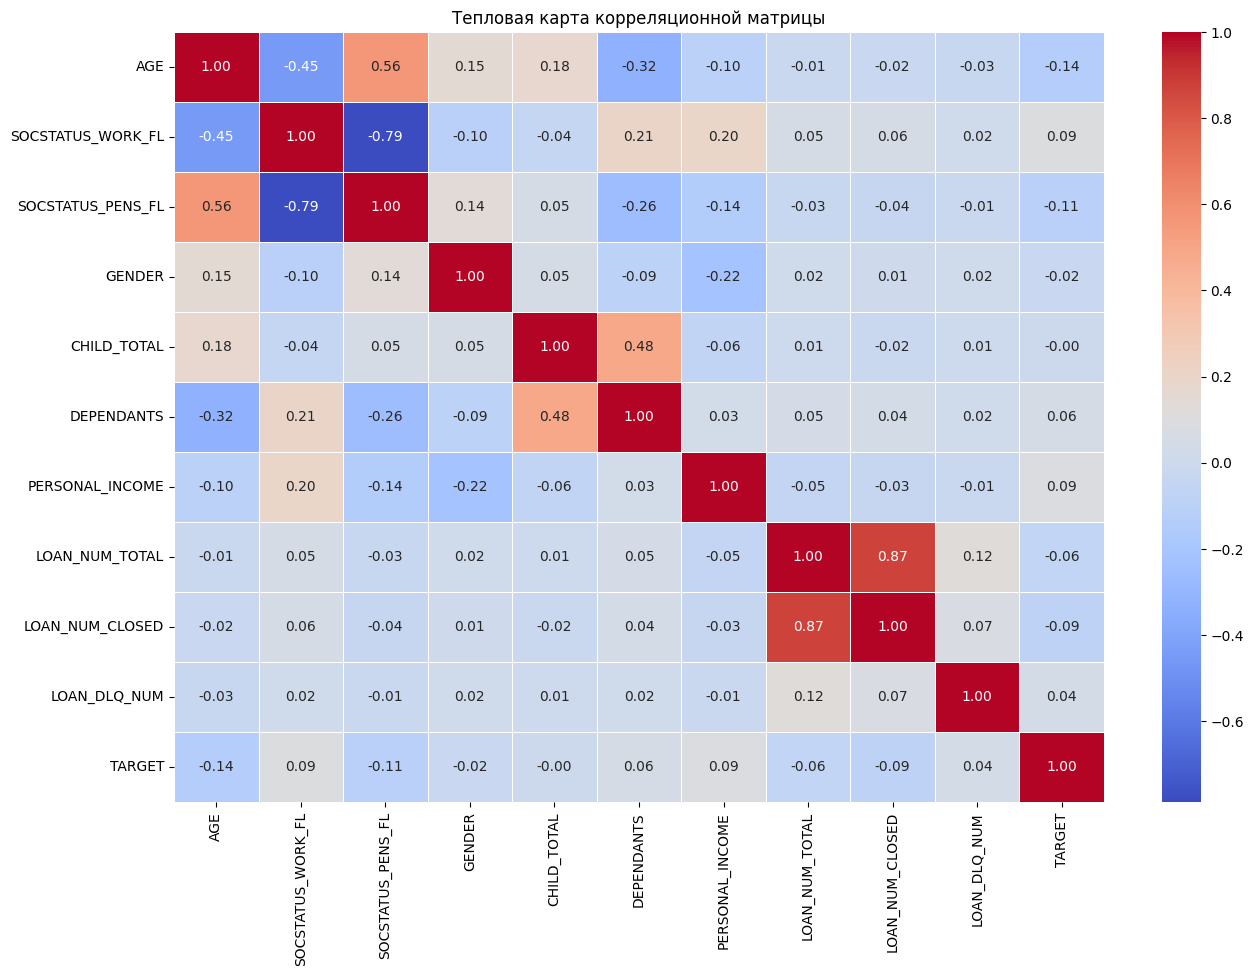

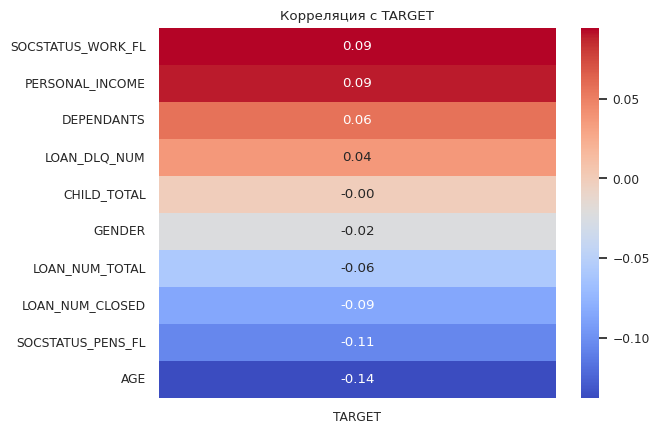

In [6]:
# Вычисляем корреляционную матрицу для обработанного DataFrame
correlation_matrix = data.corr()

# Настраиваем размеры тепловой карты
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Тепловая карта корреляционной матрицы")
plt.show()

# Вычисляем корреляцию между всеми переменными и сохраняем в переменной corr
corr = data.corr()
target_corr = corr['TARGET'].drop('TARGET')

# Сортируем корреляции по убыванию
target_corr_sorted = target_corr.sort_values(ascending=False)

# Настраиваем параметры визуализации для тепловой карты
sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Корреляция с TARGET')
plt.show()



In [8]:
# Определение независимых и зависимых переменных
X = data.drop(columns=['TARGET'])  # Убираем идентификатор и целевую переменную
y = data['TARGET']  # Целевая переменная

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Выводим размеры выборок
print(f"Размеры: X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

Размеры: X_train: (9923, 10), X_test: (2481, 10), y_train: (9923,), y_test: (2481,)


In [9]:
# Построение модели логистической регрессии (используем логистическую регрессию для бинарной классификации)
model = LogisticRegression(max_iter=1000, random_state=42)

In [10]:
# Обучение модели на обучающей выборке
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

In [11]:
# Предсказание откликов на тестовой выборке
y_test_pred = model.predict(X_test)

In [12]:
# Оценка точности предсказаний
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

In [13]:
# Вывод метрик
print("\nМетрики качества модели на тестовой выборке:")
print(f"Точность (Accuracy): {accuracy:.2f}")
print(f"Точность положительных предсказаний (Precision): {precision:.2f}")
print(f"Полнота (Recall): {recall:.2f}")
print(f"F1-мера: {f1:.2f}")


Метрики качества модели на тестовой выборке:
Точность (Accuracy): 0.86
Точность положительных предсказаний (Precision): 0.00
Полнота (Recall): 0.00
F1-мера: 0.00


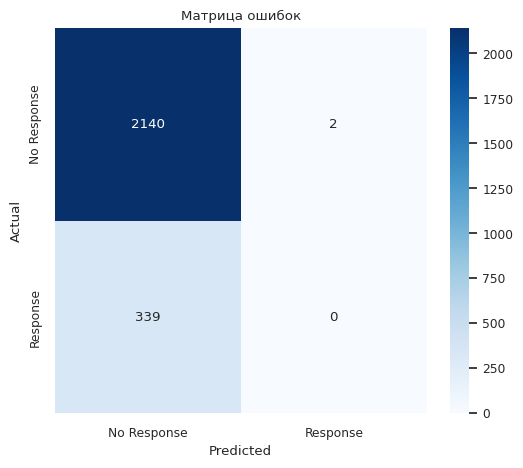

In [ ]:
# 9. Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Response', 'Response'], yticklabels=['No Response', 'Response'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Матрица ошибок')
plt.show()